# 06 — Experiments & Comparison

**Objectif :**
- comparer de manière reproductible plusieurs méthodes (baselines + Monte Carlo),
- sur plusieurs **seeds** et plusieurs tailles d’instances,
- produire des **tableaux** (moyenne, écart-type, min, max),
- sauvegarder les résultats et générer des figures prêtes pour le rapport.

Méthodes comparées :
- Random baseline
- Greedy SPT
- Greedy EDD
- Monte Carlo Random Search (MC)
- Simulated Annealing (SA)



In [1]:
import json
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path("/content")
INSTANCES_DIR = BASE_DIR / "data" / "instances"
RESULTS_DIR   = BASE_DIR / "data" / "results"
FIG_DIR       = BASE_DIR / "report" / "figures"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("INSTANCES_DIR:", INSTANCES_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIG_DIR:", FIG_DIR)


INSTANCES_DIR: /content/data/instances
RESULTS_DIR: /content/data/results
FIG_DIR: /content/report/figures


## 1) Fonctions utilitaires

On définit :
- chargement instance
- simulation + score
- baselines (Random, Greedy SPT/EDD)
- Monte Carlo (MC Random Search, SA)
- fonctions statistiques (mean/std/min/max)


In [2]:
def load_instance(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def is_valid_solution(solution, n_jobs):
    flat = [job for seq in solution for job in seq]
    return (len(flat) == n_jobs) and (sorted(flat) == list(range(n_jobs)))

def simulate(instance, solution):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    p = instance["processing_times"]
    releases = instance.get("releases", None)
    if releases is None:
        releases = [0.0] * n_jobs

    start = [0.0] * n_jobs
    end = [0.0] * n_jobs
    machine_time = [0.0] * n_machines

    for k in range(n_machines):
        t = 0.0
        for j in solution[k]:
            t = max(t, float(releases[j]))
            start[j] = t
            t += float(p[j][k])
            end[j] = t
        machine_time[k] = t

    Cmax = max(end) if end else 0.0
    return {"start": start, "end": end, "machine_time": machine_time, "Cmax": Cmax}

def compute_score(instance, sim, alpha=1.0, beta=0.2, gamma=0.0):
    end = sim["end"]
    Cmax = float(sim["Cmax"])

    deadlines = instance.get("deadlines", None)
    weights = instance.get("weights", None)

    sumT = 0.0
    sumWT = 0.0

    if deadlines is not None:
        for j in range(instance["n_jobs"]):
            tj = max(0.0, float(end[j]) - float(deadlines[j]))
            sumT += tj
            if weights is not None:
                sumWT += float(weights[j]) * tj

    score = alpha * Cmax + beta * sumT + gamma * sumWT
    return score, {"Cmax": Cmax, "sumT": sumT, "sumWT": sumWT, "score": score}


In [3]:
def random_solution(instance, rng):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    jobs = list(range(n_jobs))
    rng.shuffle(jobs)

    sol = [[] for _ in range(n_machines)]
    for j in jobs:
        k = rng.randrange(n_machines)
        sol[k].append(j)
    for k in range(n_machines):
        rng.shuffle(sol[k])
    return sol

def job_order(instance, rule="SPT"):
    p = np.array(instance["processing_times"], dtype=float)

    if rule.upper() == "SPT":
        avg_p = p.mean(axis=1)
        return list(np.argsort(avg_p))

    if rule.upper() == "EDD":
        d = instance.get("deadlines", None)
        if d is None:
            raise ValueError("EDD nécessite des deadlines.")
        return list(np.argsort(np.array(d, dtype=float)))

    raise ValueError("rule must be 'SPT' or 'EDD'")

def greedy_list_scheduling(instance, rule="SPT"):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    p = instance["processing_times"]
    releases = instance.get("releases", None)
    if releases is None:
        releases = [0.0] * n_jobs

    order = job_order(instance, rule=rule)
    sol = [[] for _ in range(n_machines)]
    machine_time = [0.0] * n_machines

    for j in order:
        best_k, best_finish = None, float("inf")
        for k in range(n_machines):
            start_j = max(machine_time[k], float(releases[j]))
            finish_j = start_j + float(p[j][k])
            if finish_j < best_finish:
                best_finish = finish_j
                best_k = k
        sol[best_k].append(j)
        machine_time[best_k] = best_finish

    return sol


In [4]:
def mc_random_search(instance, K=5000, seed=0, alpha=1.0, beta=0.2, gamma=0.0):
    rng = random.Random(seed)
    best_score = float("inf")
    best_met = None

    t0 = time.time()
    for _ in range(K):
        sol = random_solution(instance, rng)
        score, met = compute_score(instance, simulate(instance, sol), alpha, beta, gamma)
        if score < best_score:
            best_score = score
            best_met = met
    elapsed = time.time() - t0
    return best_met, elapsed

def swap_intra(sol, rng):
    new = [seq[:] for seq in sol]
    k = rng.randrange(len(new))
    if len(new[k]) < 2:
        return new
    i, j = rng.sample(range(len(new[k])), 2)
    new[k][i], new[k][j] = new[k][j], new[k][i]
    return new

def move_inter(sol, rng):
    new = [seq[:] for seq in sol]
    ks = [k for k in range(len(new)) if len(new[k]) > 0]
    if not ks:
        return new
    ka = rng.choice(ks)
    idx = rng.randrange(len(new[ka]))
    job = new[ka].pop(idx)
    kb = rng.randrange(len(new))
    pos = rng.randrange(len(new[kb]) + 1)
    new[kb].insert(pos, job)
    return new

def swap_inter(sol, rng):
    new = [seq[:] for seq in sol]
    ks = [k for k in range(len(new)) if len(new[k]) > 0]
    if len(ks) < 2:
        return new
    ka, kb = rng.sample(ks, 2)
    ia = rng.randrange(len(new[ka]))
    ib = rng.randrange(len(new[kb]))
    new[ka][ia], new[kb][ib] = new[kb][ib], new[ka][ia]
    return new

def random_neighbor(sol, rng):
    op = rng.choice([swap_intra, move_inter, swap_inter])
    return op(sol, rng)

def simulated_annealing(instance, n_iters=5000, T0=1.0, cooling=0.995, seed=0, alpha=1.0, beta=0.2, gamma=0.0):
    rng = random.Random(seed)
    sol = random_solution(instance, rng)
    score, met = compute_score(instance, simulate(instance, sol), alpha, beta, gamma)

    best_score = score
    best_met = met

    T = float(T0)
    t0 = time.time()

    for _ in range(n_iters):
        cand = random_neighbor(sol, rng)
        cand_score, cand_met = compute_score(instance, simulate(instance, cand), alpha, beta, gamma)
        delta = cand_score - score

        accept = (delta <= 0) or (rng.random() < math.exp(-delta / max(T, 1e-12)))
        if accept:
            sol = cand
            score = cand_score
            met = cand_met
            if score < best_score:
                best_score = score
                best_met = met

        T *= cooling

    elapsed = time.time() - t0
    return best_met, elapsed


## 2) Protocole expérimental

On évalue chaque méthode sur plusieurs seeds (pour les méthodes aléatoires).
Pour les méthodes déterministes (SPT/EDD), un seul run suffit.

Paramètres par défaut :
- score : $(alpha=1), $(beta=0.2), $(gamma=0)
- MC : $(K=5000$)
- SA : $(n_iters=5000), $(T_0=1.0$), cooling $(=0.995$)

On stocke les résultats sous forme tabulaire pour le rapport.


In [5]:
# Liste d'instances à tester (ajoute d'autres fichiers ici si tu en génères)
instance_files = [
    "/content/data/instances/instance_50jobs_5machines.json"
]

alpha, beta, gamma = 1.0, 0.2, 0.0
K = 5000
SA_ITERS = 5000
T0 = 1.0
COOLING = 0.995

seeds = list(range(10))  # 10 seeds = robuste et rapide


## 3) Exécution des expériences

On construit un tableau contenant pour chaque :
- instance
- méthode
- seed (si applicable)
- Cmax, sumT, score
- temps de calcul (secondes)


In [6]:
rows = []

for inst_path in instance_files:
    inst = load_instance(inst_path)
    inst_name = inst["name"]
    has_deadlines = inst.get("deadlines") is not None

    # Deterministic baselines
    sol_spt = greedy_list_scheduling(inst, "SPT")
    met_spt_score, met_spt = compute_score(inst, simulate(inst, sol_spt), alpha, beta, gamma)
    rows.append({"instance": inst_name, "method": "Greedy SPT", "seed": None, **met_spt, "time_s": 0.0})

    if has_deadlines:
        sol_edd = greedy_list_scheduling(inst, "EDD")
        met_edd_score, met_edd = compute_score(inst, simulate(inst, sol_edd), alpha, beta, gamma)
        rows.append({"instance": inst_name, "method": "Greedy EDD", "seed": None, **met_edd, "time_s": 0.0})

    # Random baseline + MC + SA (multi-seeds)
    for s in seeds:
        rng = random.Random(s)
        sol_r = random_solution(inst, rng)
        sc, met_r = compute_score(inst, simulate(inst, sol_r), alpha, beta, gamma)
        rows.append({"instance": inst_name, "method": "Random", "seed": s, **met_r, "time_s": 0.0})

        met_mc, t_mc = mc_random_search(inst, K=K, seed=s, alpha=alpha, beta=beta, gamma=gamma)
        rows.append({"instance": inst_name, "method": f"MC Random (K={K})", "seed": s, **met_mc, "time_s": t_mc})

        met_sa, t_sa = simulated_annealing(inst, n_iters=SA_ITERS, T0=T0, cooling=COOLING, seed=s, alpha=alpha, beta=beta, gamma=gamma)
        rows.append({"instance": inst_name, "method": f"SA (iters={SA_ITERS})", "seed": s, **met_sa, "time_s": t_sa})

df = pd.DataFrame(rows)
df.head(10)


,instance,method,seed,Cmax,sumT,sumWT,score,time_s
0,instance_50jobs_5machines,Greedy SPT,NaN,59.0,0.000000,0.0,59.000000,0.000000
1,instance_50jobs_5machines,Greedy EDD,NaN,51.0,0.000000,0.0,51.000000,0.000000
2,instance_50jobs_5machines,Random,0.0,157.0,372.468356,0.0,231.493671,0.000000
3,instance_50jobs_5machines,MC Random (K=5000),0.0,98.0,83.800279,0.0,114.760056,0.860080
4,instance_50jobs_5machines,SA (iters=5000),0.0,53.0,0.000000,0.0,53.000000,0.162396
5,instance_50jobs_5machines,Random,1.0,174.0,518.095153,0.0,277.619031,0.000000
6,instance_50jobs_5machines,MC Random (K=5000),1.0,104.0,47.952167,0.0,113.590433,0.373110
7,instance_50jobs_5machines,SA (iters=5000),1.0,50.0,0.000000,0.0,50.000000,0.165606
8,instance_50jobs_5machines,Random,2.0,154.0,613.677487,0.0,276.735497,0.000000
9,instance_50jobs_5machines,MC Random (K=5000),2.0,103.0,29.407082,0.0,108.881416,0.399888


## 4) Analyse qualitative des résultats bruts (seed par seed)

Le tableau ci-dessus présente les résultats **avant agrégation**, pour une instance donnée et plusieurs seeds.
Il permet d’observer directement la **variabilité** et la **stabilité** des méthodes.

**Observations principales :**
- La baseline **Random** génère des plannings de faible qualité : le makespan est élevé et le retard total
  (\(\text{sumT}\)) est important. Les résultats varient fortement selon la seed, ce qui reflète une grande
  instabilité de cette approche.
- La méthode **Monte Carlo Random Search** améliore nettement Random en sélectionnant le meilleur planning
  parmi \(K\) échantillons. On observe une baisse significative du score et du retard total, mais les résultats
  restent généralement éloignés des meilleures solutions trouvées par des approches plus guidées.
- Le **recuit simulé (Simulated Annealing)** obtient les meilleurs résultats sur ces exécutions : les scores
  sont faibles et la plupart du temps associés à un retard nul (\(\text{sumT}=0\)). Cela indique que l’exploration
  locale guidée (voisinages + acceptation probabiliste) permet d’atteindre des régions de l’espace des solutions
  de très haute qualité.
- Les heuristiques gloutonnes **SPT** et **EDD** fournissent des références déterministes. Sur cette instance,
  **EDD** est particulièrement performant grâce à l’utilisation explicite des deadlines.

Dans la section suivante, nous regroupons ces exécutions par méthode afin de produire une comparaison
statistique robuste (moyenne, écart-type, minimum, maximum).


In [7]:
def summarize(group):
    return pd.Series({
        "score_mean": group["score"].mean(),
        "score_std": group["score"].std(ddof=1) if len(group) > 1 else 0.0,
        "score_min": group["score"].min(),
        "score_max": group["score"].max(),
        "Cmax_mean": group["Cmax"].mean(),
        "Cmax_std": group["Cmax"].std(ddof=1) if len(group) > 1 else 0.0,
        "sumT_mean": group["sumT"].mean(),
        "sumT_std": group["sumT"].std(ddof=1) if len(group) > 1 else 0.0,
        "time_mean_s": group["time_s"].mean(),
    })

summary = (
    df.groupby(["instance", "method"], dropna=False)
      .apply(summarize)
      .reset_index()
      .sort_values(["instance", "score_mean"])
)

summary


/tmp/ipython-input-3447523569.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize)


,instance,method,score_mean,score_std,score_min,score_max,Cmax_mean,Cmax_std,sumT_mean,sumT_std,time_mean_s
4,instance_50jobs_5machines,SA (iters=5000),50.100000,2.131770,47.000000,53.000000,50.1,2.131770,0.000000,0.000000,0.16890
0,instance_50jobs_5machines,Greedy EDD,51.000000,0.000000,51.000000,51.000000,51.0,0.000000,0.000000,0.000000,0.00000
1,instance_50jobs_5machines,Greedy SPT,59.000000,0.000000,59.000000,59.000000,59.0,0.000000,0.000000,0.000000,0.00000
2,instance_50jobs_5machines,MC Random (K=5000),108.455279,6.677234,96.812541,116.482470,98.0,5.163978,52.276394,23.786512,0.43191
3,instance_50jobs_5machines,Random,247.857710,54.611286,162.217953,354.158572,155.1,20.733494,463.788552,182.117146,0.00000


## 5) Visualisation — comparaison des scores moyens

On trace un graphique des **scores moyens** par méthode pour une lecture rapide.


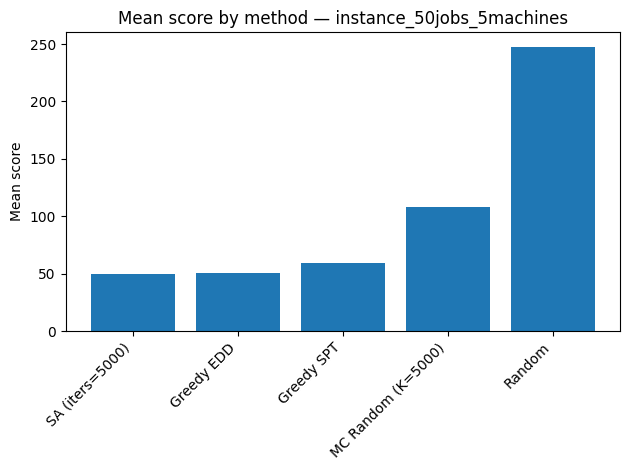

In [8]:
# On ne plot que pour une instance à la fois (lisible)
inst_name = summary["instance"].iloc[0]
sub = summary[summary["instance"] == inst_name].copy()

plt.figure()
plt.bar(sub["method"], sub["score_mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean score")
plt.title(f"Mean score by method — {inst_name}")
plt.tight_layout()
plt.show()


## 6) Sauvegarde des résultats

On sauvegarde :
- `raw_results.csv` : toutes les exécutions (seed par seed)
- `summary_results.csv` : tableau agrégé (moyenne/écart-type/min/max)

Ces fichiers sont utilisables directement dans le rapport.


In [9]:
raw_path = RESULTS_DIR / "raw_results.csv"
sum_path = RESULTS_DIR / "summary_results.csv"

df.to_csv(raw_path, index=False)
summary.to_csv(sum_path, index=False)

print("Saved raw:", raw_path)
print("Saved summary:", sum_path)


Saved raw: /content/data/results/raw_results.csv
Saved summary: /content/data/results/summary_results.csv


## 7) Sauvegarde des figures pour le rapport

On sauvegarde les figures dans `report/figures/`.


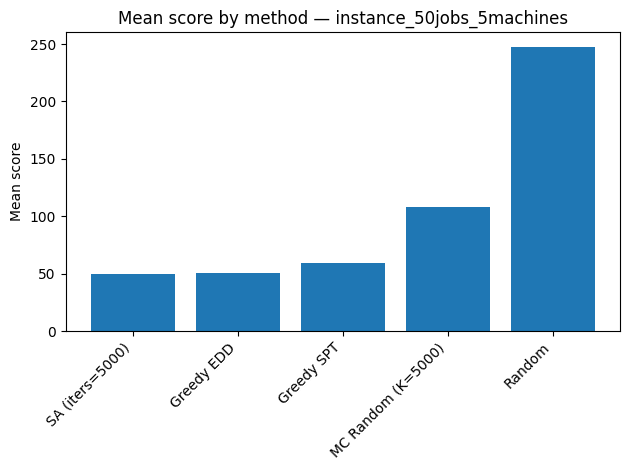

Saved figure: /content/report/figures/mean_score_instance_50jobs_5machines.png


In [10]:
fig_path = FIG_DIR / f"mean_score_{inst_name}.png"

plt.figure()
plt.bar(sub["method"], sub["score_mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean score")
plt.title(f"Mean score by method — {inst_name}")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved figure:", fig_path)



La figure ci-dessus présente le **score moyen** obtenu par chaque méthode
sur l’instance *instance_50jobs_5machines*.

Plusieurs observations majeures peuvent être formulées :

- La méthode **Random** affiche de loin le score moyen le plus élevé.
  Cela confirme que l’exploration purement aléatoire génère des plannings
  de faible qualité et très peu robustes.

- **Monte Carlo Random Search** améliore significativement la baseline Random
  en conservant le meilleur planning parmi un grand nombre d’échantillons.
  Toutefois, son score moyen reste nettement supérieur à celui des méthodes
  guidées, ce qui montre les limites de l’échantillonnage Monte Carlo non guidé.

- Les heuristiques gloutonnes **SPT** et **EDD** obtiennent de bons résultats,
  en particulier **EDD**, qui exploite efficacement l’information sur les deadlines.
  Ces méthodes servent ici de références déterministes fortes.

- Le **recuit simulé (Simulated Annealing)** atteint le **meilleur score moyen**
  parmi toutes les méthodes testées. Il combine une exploration aléatoire
  avec une exploitation locale efficace, ce qui lui permet de trouver
  systématiquement des plannings de très haute qualité.

Cette comparaison met clairement en évidence l’intérêt des méthodes
**Monte Carlo guidées**, capables de rivaliser, voire de dépasser,
des heuristiques spécialisées tout en restant génériques.


## 8) Conclusion

Nous avons exécuté un protocole expérimental reproductible comparant :
- baselines (Random, Greedy SPT/EDD),
- Monte Carlo Random Search,
- recuit simulé (Simulated Annealing),

sur plusieurs seeds. Les résultats sont synthétisés via des statistiques (moyenne, écart-type)
et sauvegardés sous forme de tableaux et figures prêtes pour le rapport.

 Prochaine étape : **07_Demo_Final.ipynb**
- exécuter le pipeline complet sur une instance,
- afficher le meilleur planning,
- produire un Gantt final + métriques finales.
